In [1]:
data = 'LabelledData (1).txt'

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import operator
import string
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

Add a length column for visualization purposee

In [3]:
df = pd.read_table(data,  sep = ',,,',names=['text','label'],index_col=False)
df['length'] = df['text'].apply(len)

In [4]:
df.head()

,text,label,length
0,how did serfdom develop in and then leave russ...,unknown,51
1,what films featured the character popeye doyle ?,what,49
2,how can i find a list of celebrities ' real na...,unknown,52
3,what fowl grabs the spotlight after the chines...,what,69
4,what is the full form of .com ?,what,32


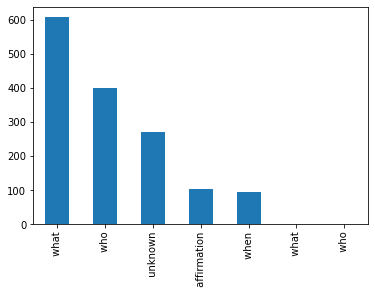

In [5]:
df.label.value_counts().plot(kind='bar')

Some have white spaces so remove them

In [6]:
df.label = df.label.str.strip()

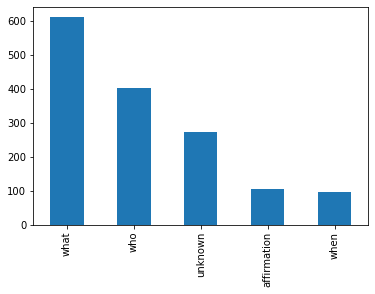

In [7]:
df.label.value_counts().plot(kind='bar')

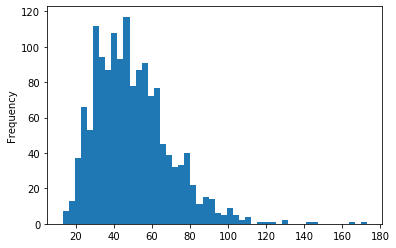

In [8]:
df['length'].plot(bins=50, kind='hist')

Max length is around 120

In [9]:
word_vector_path = "glove_new.txt"
vector_dim = 50
# gensim.scripts.glove2word2vec.glove2word2vec(word_vector_path, "data/glove2.txt")
word_vector = gensim.models.KeyedVectors.load_word2vec_format("glove.txt", binary=False)

In [10]:
def create_vector(question):
    global word_vector
    
    splitted = question.split(" ")
    vector = np.zeros(vector_dim)
    count = 2.0
    try:
        if len(splitted) == 0:
            return vector
        else:
            vector = np.array(list(map(operator.add,word_vector[splitted[0].lower()],vector)))
            if len(splitted) == 1:
                return np.asarray(vector)
            vector = np.array(list(map(operator.add,word_vector[splitted[1].lower()],vector)))
            if (splitted[0].lower() == 'what' and
                    splitted[1].lower() == 'is'):
                count = 0.0
                vector = np.zeros(vector_dim)
                for token in splitted:
                    count += 1
                    try:
                        vector = np.array(list(map(operator.add,word_vector[token.lower()],vector)))
                    except KeyError:
                        count -=1
                if count == 0:
                    return np.asarray(vector)
                return np.asarray(vector) / count
            return np.asarray(vector) / count
    except KeyError:
        return vector

In [11]:
classes = list(df.label.unique())
text = list(df.text.values)
X = [create_vector(i) for i in text]
encoder = LabelEncoder()
encoder.fit(classes)
Y = encoder.transform([i for i in list(df.label.values)])
labels = classes

In [12]:


logreg = LogisticRegression(multi_class='multinomial',solver='lbfgs')
logreg.fit(X, Y)



y_pred = logreg.predict(X)

print(classification_report(Y, y_pred,target_names=labels))

def get_top_k_predictions(model,X_test,k):
    probs = model.predict_proba(X_test)
    best_n = np.argsort(probs, axis=1)[:,-k:]
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    preds=[ item[::-1] for item in preds]
    return preds
 

              precision    recall  f1-score   support

     unknown       0.96      0.94      0.95       104
        what       0.91      0.84      0.87       272
        when       0.93      0.95      0.94       609
         who       0.91      0.97      0.94        96
 affirmation       0.99      1.00      0.99       402

    accuracy                           0.94      1483
   macro avg       0.94      0.94      0.94      1483
weighted avg       0.94      0.94      0.94      1483



The weighted avg scores are 0.94(previous 0.96) but here the model is able to learn from embeddings not just words.

In [13]:
def predict_question(x):
    if len(x)==1:
        vector = create_vector(x[0].lower())
        vector = [vector]
    else:
        vector = [create_vector(i.lower()) for i in x]
    preds = logreg.predict(vector)
    transformed_vector = encoder.inverse_transform(preds)
    return transformed_vector

In [14]:
predict_question(['who are you?'])

array(['who'], dtype='<U11')

In [15]:
test_data = ["What's your name?", 'When is the show happening?', 'Is there a cab available for airport?', 'What time does the train leave?']
predict_question(test_data)

array(['what', 'when', 'affirmation', 'when'], dtype='<U11')

With the help of pre-trained embeddings we are able to predict the ambigious sentences also!. Deep learning is not best in this case due to lack of training data otherwise we may be able to get more precise predictions.